In [1]:
# The MIT License (MIT) Copyright (c) 2024 Andrés Urbano Andrea, Núñez Quintana Luis Axel & Ramírez Gómez María Emilia
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Andrea585976/ArtEmis-ProyectoPLN/blob/main/models/artemis_transformers_unique.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Image Captioning Transformer


- This notebook explores the combination of Transformers and CNNs for image captioning, showcasing their remarkable ability to generate descriptive textual captions based on visual content.

## 0. Dependencias

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import PIL
from PIL import Image
import random
import time
import torch
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
import torchvision
from torchvision import transforms

torch.__version__

'2.2.1+cu121'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

In [4]:
# Download dataset
if not os.path.exists('img'):
  !wget https://github.com/Andrea585976/ArtEmis-ProyectoPLN/raw/main/img.zip
  !unzip img.zip
  !rm img.zip
if not os.path.exists('romanticism_dataset.csv'):
  !wget https://raw.githubusercontent.com/Andrea585976/ArtEmis-ProyectoPLN/main/romanticism_dataset.csv


In [5]:
# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv('romanticism_dataset.csv')
print(df.columns)

images = df.loc[:, ['painting', 'utterance']]
images['painting'] = images['painting'].apply(lambda x: 'img/' + x + '.jpg')

images.head(10)

Index(['painting', 'emotion', 'utterance', 'repetition'], dtype='object')


,painting,utterance
0,img/viktor-vasnetsov_ivan-tsarevich-riding-the...,The scene is quite beautiful and reminds me of...
1,img/viktor-vasnetsov_ivan-tsarevich-riding-the...,There is a sense of romance between the two pe...
2,img/william-turner_fishermen-at-sea.jpg,"There is a spooky feel to this image, with the..."
3,img/william-turner_fishermen-at-sea.jpg,The boat makes a dangerous journey alone at ni...
4,img/paul-cezanne_the-oilmill-1871.jpg,The village looks very rudimentary with it's s...
5,img/n.c.-wyeth_merlin-taking-away-the-infant-a...,It looks like the baby is being taken for what...
6,img/orest-kiprensky_the-family-of-satyrs.jpg,The imps playfully dance and sing to the music.
7,img/sir-lawrence-alma-tadema_strigils-and-spon...,The women appear quite interested in one anoth...
8,img/orest-kiprensky_putto-with-a-globe.jpg,The little boy is trying to roll the globe aro...
9,img/sir-lawrence-alma-tadema_pleading-1876.jpg,The man laying down in this painting feels lik...


- Download images:

In [6]:
# Convertir df_subset en un arreglo NumPy sin nombres de columnas
images = images.values
len(images)

39069

- Dataset split

In [7]:
random.Random(77).shuffle(images)

num_val_samples = int(0.05 * len(images))
train_images = images[num_val_samples:]
val_images= images[:num_val_samples]
len(train_images), len(val_images)

(37116, 1953)

In [8]:
def generate_tuples(paths):
    tuples = []
    for image_path, text in paths:
        if os.path.exists(image_path):  # Verificar si la imagen existe en la ruta
            tuples.append((image_path, text.strip()))
    return tuples

train_tuples = generate_tuples(train_images)
val_tuples = generate_tuples(val_images)

len(train_tuples), len(val_tuples)

(36732, 1953)

In [9]:
for tuple in train_tuples[:2]:
    print(tuple)

('img/gustave-dore_samson-carries-away-the-gates-of-gaza.jpg', 'The dark painting is far from my favorite, but the animal by the ocean is still a beautiful scene.')
('img/gustave-dore_the-inferno-canto-12-2.jpg', 'The black and grey colors combined with the violent figures')


## 2.- Pipeline

- Create vocabulary and tokenizer.

In [10]:
tokenizer = get_tokenizer('basic_english')

In [11]:
def build_vocab(text, tokenizer):
    counter = Counter()
    for _, string_ in text:
        counter.update(tokenizer(string_))
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


vocab = build_vocab(train_tuples, tokenizer)
vocab.set_default_index(0) # fix <ukn>

In [12]:
vocab_size = len(vocab)
vocab_size

12293

In [13]:
image_size = 128
batch_size = 64
maxlen = 36

PAD_IDX = vocab['<pad>']
BOS_IDX = vocab['<bos>']
EOS_IDX = vocab['<eos>']
PAD_IDX, BOS_IDX, EOS_IDX

(1, 2, 3)

* Retrieve a random unique desc for img

In [14]:
#Create dictionaries to retrieve unique random description for each image
train_dict = {}
val_dict = {}

for path, desc in train_tuples:
    if path not in train_dict:
        train_dict[path] = []
    train_dict[path].append(desc)

for path, desc in val_tuples:
    if path not in val_dict:
        val_dict[path] = []
    val_dict[path].append(desc)

In [15]:
def retrieve_random_unique_desc():
  random_train = []
  random_val = []
  for path in train_dict:
      random_train.append((path, random.choice(train_dict[path])))

  for path in val_dict:
      random_val.append((path, random.choice(val_dict[path])))

  return random_train, random_val

In [16]:
random_train, random_val = retrieve_random_unique_desc()

len(train_tuples), len(random_train), len(val_tuples), len(random_val)

(36732, 6237, 1953, 948)

- Reduce dataset size for simplicity

In [17]:
def data_process(text):
    data = []
    for x, y in text:
        tensor_ = torch.tensor(
            [vocab[token] for token in tokenizer(y)],
            dtype=torch.long
        )

        if tensor_.shape[0] < maxlen:
            data.append((x, tensor_))

    return data

random_train, random_val = retrieve_random_unique_desc()

train_data = data_process(random_train)
val_data = data_process(random_val)
len(train_data), len(val_data)

(5999, 930)

In [18]:
transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
])

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        image = Image.open(x_item).convert('RGB')
        image = transform(image)
        x.append(image)
        y.append(
            torch.cat([
                torch.tensor([BOS_IDX]),
                y_item,
                torch.tensor([EOS_IDX])
            ], dim=0)
        )

    x = torch.stack(x)
    y = pad_sequence(y, batch_first=True, padding_value=PAD_IDX)
    return x, y[:, :-1], y[:, 1:]

train_loader = DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                    shuffle=False, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

In [19]:
enc_batch, dec_batch, target_batch = next(iter(val_loader))
enc_batch.shape, dec_batch.shape, target_batch.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([64, 3, 128, 128]), torch.Size([64, 33]), torch.Size([64, 33]))

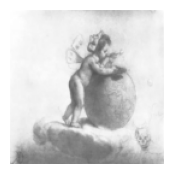

Ground truth: the little boy is trying to roll the globe around like a toy                    


In [20]:
def plot_img(img, target):
    image_array = img.permute(1, 2, 0).numpy()
    image_text = " ".join(
        [vocab.get_itos()[_] for _ in target]
    ).replace("<pad>", "").replace("<eos>", "")

    fig = plt.figure(figsize=(2, 2))

    # Plot the image
    plt.imshow(image_array)
    #plt.title(image_text)
    plt.axis('off')  # Optional: Turn off axes
    plt.show()
    print(f'Ground truth: {image_text}')

idx = 10
plot_img(enc_batch[idx], target_batch[idx])

## 3.- Model

### Feature extraction block
- Define a convolutional network for image feature extraction.

In [21]:
class DownBlockComp(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(DownBlockComp, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 3, 2, 1, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True),
        )

        self.direct = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.Conv2d(in_planes, out_planes, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True))

    def forward(self, feat):
        return (self.main(feat) + self.direct(feat)) / 2

In [22]:
class CNN(nn.Module):
    def __init__(self, filters=128, noise_dim=64):
        super(CNN, self).__init__()
        self.filters = filters
        self.down_block = nn.Sequential(
            nn.Conv2d(3, filters // 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(filters // 8), nn.LeakyReLU(0.2, inplace=True),
            DownBlockComp(filters // 8, filters // 4),
            DownBlockComp(filters // 4, filters // 2),
            DownBlockComp(filters // 2, filters),
            DownBlockComp(filters, filters),
            nn.Conv2d(filters, filters, 3, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.down_block(x)
        x = torch.permute(x, [0, 2, 3, 1]).view(B, -1, self.filters)
        return x


discriminator = CNN(256)
out_disc = discriminator(enc_batch)
out_disc.shape

torch.Size([64, 36, 256])

### Transformer block

In [23]:
class Attention(nn.Module):
    def __init__(self, dim, maxlen, n_heads=4, bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.wq = nn.Linear(dim, dim, bias = bias)
        self.wk = nn.Linear(dim, dim, bias = bias)
        self.wv = nn.Linear(dim, dim, bias = bias)

        self.wo = nn.Linear(dim, dim, bias = bias)
        self.register_buffer("bias", torch.tril(torch.ones(maxlen, maxlen)).view(1, 1, maxlen, maxlen))

    def forward(self, x, context=None):
        B, L, D = x.shape
        out_L = L
        q = self.wq(x)
        q = torch.reshape(q, [B, L, self.n_heads, -1])
        q = torch.permute(q, [0, 2, 1, 3])

        if context == None:
            k = self.wk(x)
            v = self.wv(x)
        else:
            k = self.wk(context)
            v = self.wv(context)
            B, L, D = k.shape

        k = torch.reshape(k, [B, L, self.n_heads, -1])
        k = torch.permute(k, [0, 2, 3, 1])
        v = torch.reshape(v, [B, L, self.n_heads, -1])
        v = torch.permute(v, [0, 2, 1, 3])

        qk = torch.matmul(q, k) * self.scale
        if context == None:
            qk = qk.masked_fill(self.bias[:,:,:L,:L] == 0, float('-inf'))

        attn = torch.softmax(qk, dim=-1)

        v_attn = torch.matmul(attn, v)
        v_attn = torch.permute(v_attn, [0, 2, 1, 3])
        v_attn = torch.reshape(v_attn, [B, out_L, D])

        x = self.wo(v_attn)
        return x


q_test = torch.ones([1, 8, 32])
k_test = torch.ones([1, 64, 32])
test_layer = Attention(32, maxlen, n_heads=4)
test_layer(q_test).shape, test_layer(q_test, k_test).shape

(torch.Size([1, 8, 32]), torch.Size([1, 8, 32]))

- Define Transformer:

In [24]:
class DecoderBlock(nn.Module):
    def __init__(self, dim, maxlen, heads=4, mlp_dim=512, rate=0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, maxlen)
        self.cross_attn = Attention(dim, maxlen)
        self.ln_2 = nn.LayerNorm(dim)
        self.ln_3 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(rate),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(rate),
        )

    def forward(self, x):
        inputs, context = x
        x = self.attn(inputs)
        skip1 = self.ln_1(x + inputs)
        x = self.cross_attn(skip1, context)
        skip2 = self.ln_2(x + skip1)
        return self.ln_3(self.mlp(skip2) + skip2)


test_layer = DecoderBlock(32, maxlen)
x_test = torch.ones([1, maxlen, 32])
test_layer([x_test, x_test]).shape

torch.Size([1, 36, 32])

- Define Transformer

In [25]:
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 33]), torch.Size([64, 33]))

### Transformer

In [26]:
class Transformer(nn.Module):
    def __init__(self, dim, vocab_size, maxlen, depth=3,
                 mlp_dim=512, rate=0.2):
        super().__init__()
        self.depth = depth
        self.embedding = nn.Embedding(vocab_size, dim)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, maxlen, dim))

        self.decoder = nn.ModuleList()
        for i in range(self.depth):
            self.decoder.append(DecoderBlock(dim, maxlen))

        self.head = nn.Linear(dim, vocab_size, bias=False)
        self.cnn = CNN(dim)

    def forward(self, x, context):
        B, L = x.shape
        x = self.embedding(x)
        x += self.pos_embedding[:, :L]

        context = self.cnn(context)
        for layer in self.decoder:
            x = layer([x, context])
        x = self.head(x)
        return x


model_dim = 64
mlp_dim = 128
depth = 3

transformer = Transformer(dim=model_dim, vocab_size=vocab_size,
          maxlen=maxlen, depth=depth, mlp_dim=mlp_dim)
output = transformer(dec_batch, enc_batch)
output.shape, target_batch.shape

(torch.Size([64, 33, 12293]), torch.Size([64, 33]))

## 4.- Training

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

transformer.to(device)

cuda:0


Transformer(
  (embedding): Embedding(12293, 64)
  (decoder): ModuleList(
    (0-2): 3 x DecoderBlock(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (cross_attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=512, bias=True)
        (1): G

In [28]:
optimizer = optim.Adam(transformer.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [29]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inp_enc, inp_dec, tar_dec in train_loader:
        tar_dec = tar_dec.reshape(-1)
        inp_enc = inp_enc.to(device)
        inp_dec = inp_dec.to(device)
        tar_dec = tar_dec.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inp_dec, inp_enc)
        outputs = outputs.view(-1, outputs.size(-1))
        loss = loss_fn(outputs, tar_dec)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [30]:
def generate(model, image, device, maxlen):
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        model.eval()
        idx = torch.tensor(BOS_IDX, dtype=torch.long)
        idx = idx.reshape([1, -1])

        for _ in range(maxlen):
            idx = idx.to(device)
            logits = model(idx, image)[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

            _, idx_next = torch.topk(probs, k=1, dim=-1)
            if vocab.get_itos()[idx_next] == '<eos>':
                break
            idx = torch.cat((idx, idx_next), dim=1)

    txt = " ".join(
        [vocab.get_itos()[_] for _ in idx[0]]
    )
    print(f'Generated text: {txt.replace("<bos>", "")}')

generate(transformer, enc_batch[idx], device, maxlen)

Generated text:  scorn gothic ruminates wearing attendant getaway navigate confession cursed necklace grimmer romanesque colosseum boarder dancers tiara affect mean-looking splatter mastered marine transparency lecture rages hardness loaded deliveryman absurd literal waves message panorama cute mournfully fascinating shipwrecks


In [31]:
def random_data_for_training():
    random_train, random_val = retrieve_random_unique_desc()
    train_data = data_process(random_train)
    val_data = data_process(random_val)
    train_loader = DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

In [32]:
epochs = 100

for epoch in range(epochs):
    random_data_for_training()
    train(transformer, device, train_loader, optimizer, epoch)
    generate(transformer, enc_batch[idx], device, maxlen)


Time for epoch 0 is 9.6105 sec Train loss: 6.6058
Generated text:  the man is a and the man .

Time for epoch 1 is 8.4626 sec Train loss: 5.2205
Generated text:  the man is very very very very very .

Time for epoch 2 is 9.1359 sec Train loss: 4.8652
Generated text:  the man is very very very very very very very very very .

Time for epoch 3 is 9.5326 sec Train loss: 4.6299
Generated text:  the man is quite lovely and the background is quite lovely .

Time for epoch 4 is 9.1352 sec Train loss: 4.4445
Generated text:  the man is very well and the man ' s face and the man ' s face and the man ' s face .

Time for epoch 5 is 9.5470 sec Train loss: 4.2840
Generated text:  the man looks like he is in a bit of a sense of a sense of a sense of a sense of a lot of a feeling .

Time for epoch 6 is 8.7684 sec Train loss: 4.1371
Generated text:  the man is quite lovely and the way he is very sad .

Time for epoch 7 is 9.0044 sec Train loss: 3.9995
Generated text:  the man looks like he is in his

- Test the model on validation images.

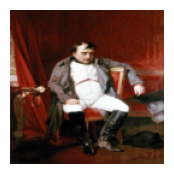

Ground truth: the man looks totally lazy since he ' s sunken deep into the chair                   
Generated text:  the man looks totally lazy since he ' s sunken deep into the chair


In [42]:
idx = 4
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], device, maxlen)

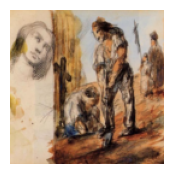

Ground truth: the people are filled with sadness as they bury their friend .                     
Generated text:  the presence of the people digging make me sorry for those who have been lost .


In [41]:
idx = 52
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], device, maxlen)

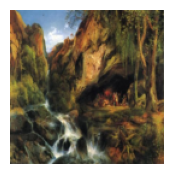

Ground truth: the water cascading down the rocks looks amazing                         
Generated text:  the water cascading down the rocks looks amazing


In [43]:
idx = 33
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], device, maxlen)